In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# EDA

In [2]:
df3 = pd.read_csv('bs140513_032310.csv')
df3.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [3]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


In [4]:
df3.describe()

,step,amount,fraud
count,594643.000000,594643.000000,594643.000000
mean,94.986827,37.890135,0.012108
std,51.053632,111.402831,0.109369
min,0.000000,0.000000,0.000000
25%,52.000000,13.740000,0.000000
50%,97.000000,26.900000,0.000000
75%,139.000000,42.540000,0.000000
max,179.000000,8329.960000,1.000000


In [5]:
# Checking for missing values
df3.isnull().sum()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64


Fraudulent vs Genuine Transactions:
0    587443
1      7200
Name: fraud, dtype: int64


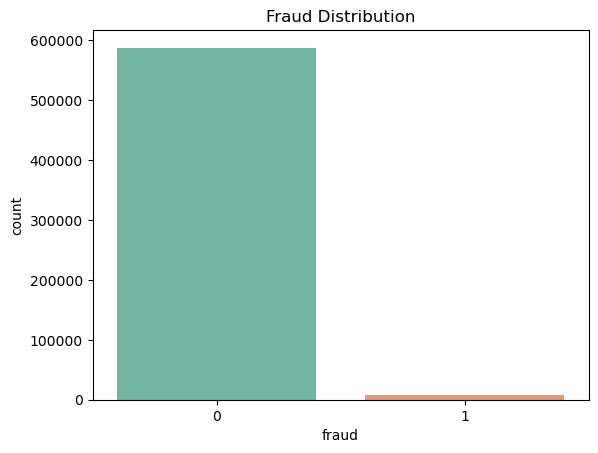

In [6]:
# Checking the distribution of the target variable
print("\nFraudulent vs Genuine Transactions:")
print(df3['fraud'].value_counts())

# Plot 1: Fraud Distribution
plt.figure()
sns.countplot(x='fraud', data=df3, palette='Set2')
plt.title('Fraud Distribution')
plt.show()

This graph and the distribution of the target variable indicates that there is an imbalance in the dataset. To deal with this imbalance, sampling techniques such as SMOTE and oversampling required.

# Splitting the Dataset

In [7]:
# Splitting the dataset
X = df3.drop('fraud', axis=1)
y = df3['fraud']

# Dropping the unnecessary columns
X = X.drop(['zipcodeOri', 'zipMerchant'], axis=1)

# Calculating the size of the validation set as a fraction of the total dataset size
validation_size = (594643 - 500000) / 594643

# Spliting the data into training and validation sets
X_train_val, X_validation, y_train_val, y_validation = train_test_split(X, y, test_size=validation_size, random_state=42)

# Defining the test size as a fraction of the training set
test_size_fraction = 100000 / 500000

# Further splitting the training set into training and test sets for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X_train_val, y_train_val, test_size=test_size_fraction, random_state=42)

The dataset is divided into two sections: `'features' (X)` and `'target' (y)`, with `'features'` serving as input variables and `'target'` indicating fraud. Columns `'zipcodeOri'` and `'zipMerchant'` are removed because they are unrelated to fraud prediction. The data is split into two sets: a training-validation set (500,000 rows) and a validation set (the remaining rows). For model creation and performance evaluation, the training validation set is further divided into a training set and a test set.

In [8]:
# Printing the shapes of the datasets to check if the split is done properly or not.
print(f"Training set features shape: {X_train.shape}")
print(f"Training set target shape: {y_train.shape}")
print(f"Testing set features shape: {X_test.shape}")
print(f"Testing set target shape: {y_test.shape}")
print(f"Validation set features shape: {X_validation.shape}")
print(f"Validation set target shape: {y_validation.shape}")

Training set features shape: (400000, 7)
Training set target shape: (400000,)
Testing set features shape: (100000, 7)
Testing set target shape: (100000,)
Validation set features shape: (94643, 7)
Validation set target shape: (94643,)


# Applying Label and One-hot Encoding

In [9]:
# Initializing the LabelEncoder
label_encoder = LabelEncoder()

# Applying Label Encoding on 'customer' and 'merchant'
X_train['customer'] = label_encoder.fit_transform(X_train['customer'])
X_test['customer'] = label_encoder.transform(X_test['customer'])
X_validation['customer'] = label_encoder.transform(X_validation['customer'])

X_train['merchant'] = label_encoder.fit_transform(X_train['merchant'])
X_test['merchant'] = label_encoder.transform(X_test['merchant'])
X_validation['merchant'] = label_encoder.transform(X_validation['merchant'])
 
# Applying one-hot encoding on 'age', 'gender', and 'category'
one_hot_encoded_columns = pd.get_dummies(X_train[['age', 'gender', 'category']], drop_first=True)

# Dropping 'age', 'gender', 'category' as they are now encoded
X_train = X_train.drop(['age', 'gender', 'category'], axis=1)

# Joining the encoded df
X_train = X_train.join(one_hot_encoded_columns)

# Applying the same transformation to the test and validation sets
X_test = X_test.join(pd.get_dummies(X_test[['age', 'gender', 'category']], drop_first=True))
X_validation = X_validation.join(pd.get_dummies(X_validation[['age', 'gender', 'category']], drop_first=True))

# Dropping the original 'age', 'gender', 'category' columns from test and validation sets as they are now encoded
X_test = X_test.drop(['age', 'gender', 'category'], axis=1)
X_validation = X_validation.drop(['age', 'gender', 'category'], axis=1)

`Label encoding` is appropriate for columns with a large number of unique categories. Hence, using `label encoding` for 'customer' and 'merchant'.

`One-hot encoding` is appropriate for columns with a small number of unique categories and where the order of the categories is not important. Hence, using `one-hot encoding` for 'age,' 'gender,' and 'category'.

# Over-sampling the Training Data

In [10]:
# Initializing SMOTE
smote = SMOTE(random_state=42)

# Fitting SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Printing the number of samples in each class after over-sampling
print("After over-sampling with SMOTE:")
print("Number of non-fraud cases (0):", sum(y_train_resampled == 0))
print("Number of fraud cases (1):", sum(y_train_resampled == 1))

After over-sampling with SMOTE:
Number of non-fraud cases (0): 395134
Number of fraud cases (1): 395134


Using SMOTE to equalise the amount of fraud and non-fraud cases by over-sampling the training set.

# Model Evaluation

## Model 1: Logistic Regression

C:\Users\musta\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     98794
           1       0.39      0.79      0.52      1206

    accuracy                           0.98    100000
   macro avg       0.69      0.89      0.76    100000
weighted avg       0.99      0.98      0.99    100000



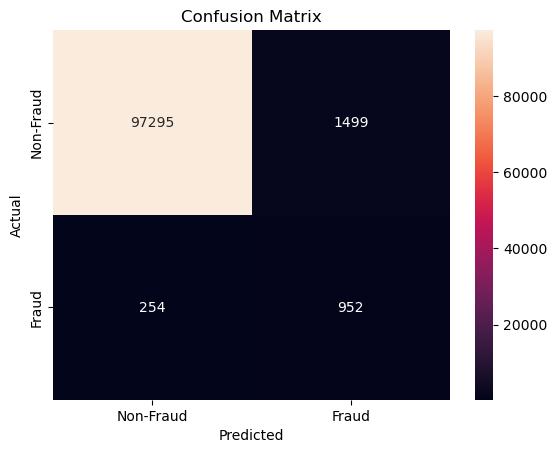

In [11]:
from sklearn.linear_model import LogisticRegression

# Initializing the Logistic Regression model
logistic_regression_model = LogisticRegression(max_iter=1000, random_state=42)

# Training the Logistic Regression model on the resampled (over-sampled) training data
logistic_regression_model.fit(X_train_resampled, y_train_resampled)

# Predicting on the original, not resampled test set
logistic_regression_predictions = logistic_regression_model.predict(X_test)

# Evaluating the Logistic Regression model
print("Logistic Regression Classification Report:")
print(classification_report(y_test, logistic_regression_predictions))

cm_lr = confusion_matrix(y_test, logistic_regression_predictions)

# Plotting the confusion matrix
sns.heatmap(cm_lr, annot=True, fmt='d', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

The Logistic Regression model is accurate in recognizing non-fraud transactions, with precision nearing 100% and recall nearing 98%, resulting in an f1-score of 0.99. However, while fraud detection has a high recall of 79%, it has a low precision of 39%, resulting in a high number of false positives. This is reflected in the f1-score of 0.52 for fraud cases. This shows that the model faces difficulty in differentiating between legitimate and fraudulent transactions. Despite a high overall accuracy of 98%, the effectiveness of fraud detection requires improvement.

Confusion matrix:

(a) `97,295 True Negatives` - Successfully identified non-fraudulent transactions.

(b) `1,499 False Positives` - Non-fraudulent transactions incorrectly identified as fraudulent.

(c) `254 False Negatives` - Fraudulent transactions incorrectly identified as non-fraudulent.

(d) `952 True Positives` - Successfully identified fraudulent transactions.

These results suggest that the model is not practical to use in a real-world banking system.

## Model 2: Decision Tree

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98794
           1       0.74      0.77      0.75      1206

    accuracy                           0.99    100000
   macro avg       0.87      0.88      0.88    100000
weighted avg       0.99      0.99      0.99    100000



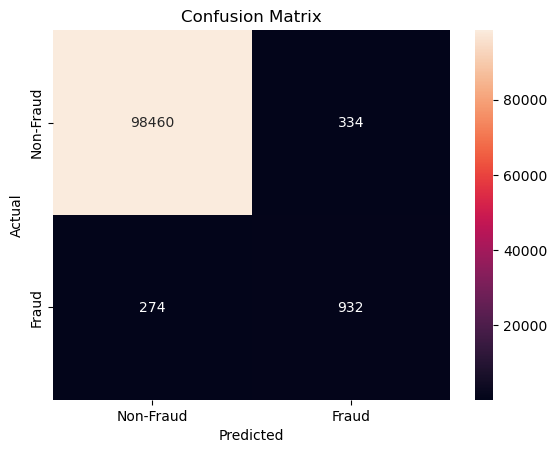

In [12]:
from sklearn.tree import DecisionTreeClassifier

# Initializing the Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Training the Decision Tree model on the resampled (over-sampled) training data
decision_tree_model.fit(X_train_resampled, y_train_resampled)

# Predicting on the original, not resampled test set
decision_tree_predictions = decision_tree_model.predict(X_test)

# Evaluating the Decision Tree model
print("Decision Tree Classification Report:")
print(classification_report(y_test, decision_tree_predictions))

cm_dt = confusion_matrix(y_test, decision_tree_predictions)

# Plotting the confusion matrix
sns.heatmap(cm_dt, annot=True, fmt='d', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In terms of identifying fraud, the Decision Tree model is better than the Logistic Regression model, with a higher precision of 74% and a recall of 77%. As a result, fewer legitimate transactions are incorrectly identified as fraudulent. Its f1-score for fraud detection is 0.75, which is a significant improvement over the Logistic Regression's 0.52, indicating a better balance in properly identifying fraud while minimizing errors.

Confusion matrix:

(a) `98,460 True Negatives` - Successfully identified non-fraudulent transactions.

(b) `334 False Positives` - Fewer mistakes in mislabeling non-fraud as fraud than Logistic Regression.

(c) `274 False Negatives` - Slightly more missed frauds than Logistic Regression.

(d) `932 True Positives` - Slightly lower than Logistic Regression, but still effectively identifies a good number of frauds.

In conclusion, the Decision Tree model performs better in detecting fraudulent transactions compared to the Logistic Regression model. But, there is still room for improvement. 

## Model 3: Random Forest

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98794
           1       0.85      0.78      0.82      1206

    accuracy                           1.00    100000
   macro avg       0.93      0.89      0.91    100000
weighted avg       1.00      1.00      1.00    100000



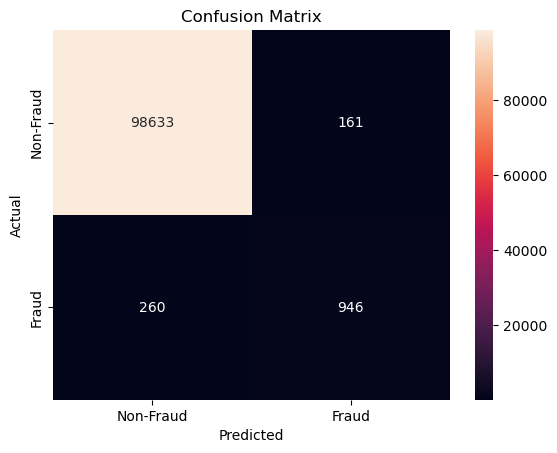

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Initializing the Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)

# Training the Random Forest model on the resampled (over-sampled) training data
random_forest_model.fit(X_train_resampled, y_train_resampled)

# Predicting on the original, not resampled test set
random_forest_predictions = random_forest_model.predict(X_test)

# Evaluating the Random Forest model
print("Random Forest Classification Report:")
print(classification_report(y_test, random_forest_predictions))

cm_rf = confusion_matrix(y_test, random_forest_predictions) 

# Plotting the confusion matrix
sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

The model performs better than the Decision Tree model, so using it on the validation set to test its performance.

## Testing Random Forest Model on Validation Set

Random Forest Validation Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93515
           1       0.85      0.79      0.82      1128

    accuracy                           1.00     94643
   macro avg       0.92      0.90      0.91     94643
weighted avg       1.00      1.00      1.00     94643



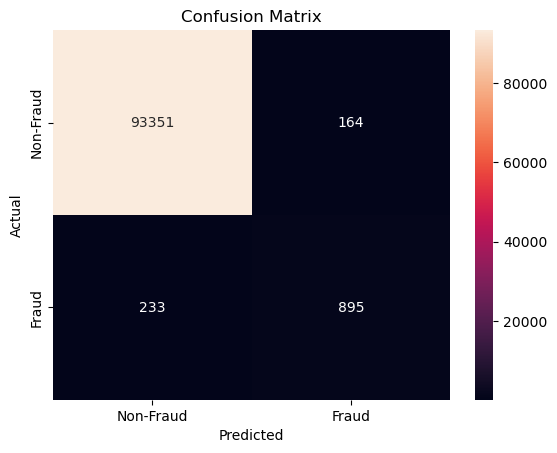

In [14]:
random_forest_validation_predictions = random_forest_model.predict(X_validation)

print("Random Forest Validation Set Classification Report:")
print(classification_report(y_validation, random_forest_validation_predictions))

cm2_rf = confusion_matrix(y_validation, random_forest_validation_predictions)

sns.heatmap(cm2_rf, annot=True, fmt='d', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

The Random Forest model is quite good at detecting fraudulent transactions, consistently showing good results on both test and validation sets. This means it works well with both known and unknown data. With a high f1-score of 0.82, precision of 85%, and recall of 79%, it outperforms the Logistic Regression and Decision Tree models in identifying fraud. This demonstrates that it correctly identifies the majority of fraud cases while not incorrectly labeling normal transactions as fraudulent. This precision is critical in fraud detection to avoid false alarms. The model's constant performance across test and validation data sets indicates its dependability and efficacy. It satisfies the needs of the bank and its customers by effectively detecting new and unseen fraudulent cases without setting off any false alarms as shown in the results given by the confusion matrix:

Confusion matrix:

(a) 93,351 True Negatives - Successfully identified non-fraudulent transactions.

(b) 164 False Positives - Non-fraudulent transactions incorrectly identified as fraudulent.

(c) 233 False Negatives - fraudulent transactions incorrectly marked as non-fraudulent.

(d) 895 True Positives - Successfully identified fraudulent transactions.

### Checking for Overfitting:

In [15]:
rf_train_pred = random_forest_model.predict(X_train)
rf_test_pred = random_forest_model.predict(X_test)
rf_validation_pred = random_forest_model.predict(X_validation)

print("Random Forest Accuracy on Training Set: ", accuracy_score(y_train, rf_train_pred))
print("Random Forest Accuracy on Test Set: ", accuracy_score(y_test, rf_test_pred))
print("Random Forest Accuracy on Validation Set: ", accuracy_score(y_validation, rf_validation_pred))

Random Forest Accuracy on Training Set:  0.9999975
Random Forest Accuracy on Test Set:  0.99579
Random Forest Accuracy on Validation Set:  0.9958052893505066


The Random Forest model has nearly perfect accuracy on the training set, but slightly lower accuracy on the test and validation sets. This disparity shows a minor degree of overfitting. Hence, we need to use another model to avoid this.

## Model 4: XGBoost

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98794
           1       0.78      0.84      0.81      1206

    accuracy                           1.00    100000
   macro avg       0.89      0.92      0.91    100000
weighted avg       1.00      1.00      1.00    100000



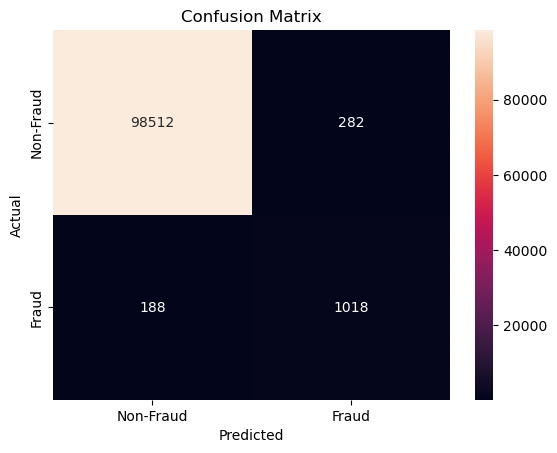

In [16]:
from xgboost import XGBClassifier

# Initializing the XGBoost model
xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Training the XGBoost model on the resampled (over-sampled) training data
xgboost_model.fit(X_train_resampled, y_train_resampled)

# Predicting on the original, not resampled test set
xgboost_predictions = xgboost_model.predict(X_test)

# Evaluating the XGBoost model
print("XGBoost Classification Report:")
print(classification_report(y_test, xgboost_predictions))

cm_xgb = confusion_matrix(y_test, xgboost_predictions)

sns.heatmap(cm_xgb, annot=True, fmt='d', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

This model performs slightly better in terms of detecting actual fradulant transactions and so checking it's performance on the validation set.

## Testing XGBoost Model on Validation Set

XGBoost Validation Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93515
           1       0.80      0.86      0.83      1128

    accuracy                           1.00     94643
   macro avg       0.90      0.93      0.91     94643
weighted avg       1.00      1.00      1.00     94643



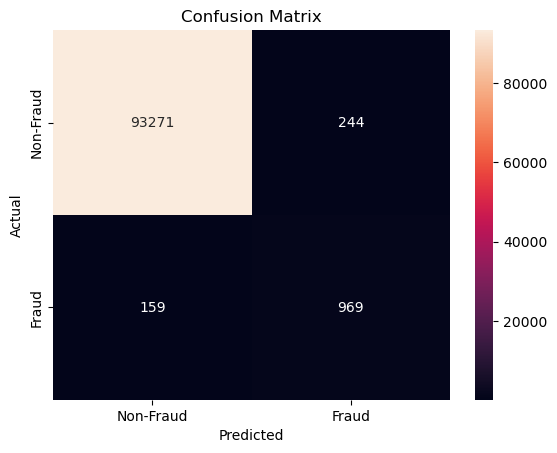

In [17]:
# Predicting with the XGBoost model on the validation set
xgboost_validation_predictions = xgboost_model.predict(X_validation)

# Evaluating the XGBoost model on the validation set
print("XGBoost Validation Set Classification Report:")
print(classification_report(y_validation, xgboost_validation_predictions))

cm2_xgb = confusion_matrix(y_validation, xgboost_validation_predictions)
                           
sns.heatmap(cm2_xgb, annot=True, fmt='d', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

For the given dataset, the XGBoost model appears as the best approach for detecting fraudulent transactions. This model not only has a high level of accuracy, but it also excels at detecting fraudulent transactions (high recall) while keeping a respectable level of precision. On the validation set, the XGBoost model achieved an impressive recall of 86% for fraudulent transactions, indicating a good ability to detect a significant portion of fraud cases. Furthermore, its balanced f1-score of 0.83 for the fraudulent class demonstrates its ability to manage the balance between detecting actual fraud payments and minimizing false positives. Given the client's need for a solution that performs well for both genuine and fraudulent transactions, the XGBoost model stands out because it offers an effective and accurate approach to fraud detection, ensuring a high detection rate of fraudulent activities with a fair error margin. This is consistent with the client's goals of obtaining high accuracy in predicting new, unseen payments while retaining great performance across both transaction types. This analysis can be highlighted by the results given by the confusion matrix:

Confusion Matrix:

(a) `93,271 True Negatives` - Successfully identified non-fraudulent transactions.

(b) `244 False Positives` - Non-fraudulent transactions incorrectly identified as fraudulent.

(c) `159 False Negatives` - fraudulent transactions incorrectly marked as non-fraudulent.

(d) `969 True Positives` - Successfully identified fraudulent transactions.

### Checking for Overfitting:

In [18]:
xgb_train_pred = xgboost_model.predict(X_train)
xgb_test_pred = xgboost_model.predict(X_test)
xgb_validation_pred = xgboost_model.predict(X_validation)

print("XGBoost Accuracy on Training Set: ", accuracy_score(y_train, xgb_train_pred))
print("XGBoost Accuracy on Test Set: ", accuracy_score(y_test, xgb_test_pred))
print("XGBoost Accuracy on Validation Set: ", accuracy_score(y_validation, xgb_validation_pred))

XGBoost Accuracy on Training Set:  0.9963225
XGBoost Accuracy on Test Set:  0.9953
XGBoost Accuracy on Validation Set:  0.9957418932197838


As it can be seen from the results above, there is almost no overfitting which makes the XGBoost model a perfect fit to fulfill the requirements of the bank and it's clients.